In [1]:
%matplotlib inline
import scipy.io
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_file

img_size = 48
emotion_list = ['neutral', 'happiness',	'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt', 'unknown']

pretrained_model = "https://files.seeedstudio.com/ml/emotion/MobileFaceNet_48_1_0-06.hdf5"
modhash = 'e9538a782b0f601c616e68b9be4f1245756e9ca603804cce62eb2a0a6b1f8b8a'

test_dataset_path = '../data/test.csv'

def load_data(path):

    d = pd.read_csv(path)
    d = d.drop(['Usage', 'NF'], axis=1)
    return d["Image name"].to_numpy(), d.iloc[:, 2:].to_numpy()/10


# download model
model_file = get_file("MobileFaceNet_48_1_0-06.hdf5", pretrained_model, cache_subdir="pretrained_models",
                        file_hash=modhash)

# load test data
test_image_list, test_data = load_data(test_dataset_path)

2021-07-28 13:54:46.509321: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2021-07-28 13:54:49.423339: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-28 13:54:49.455416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-28 13:54:49.455820: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.683GHz coreCount: 15 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 238.66GiB/s
2021-07-28 13:54:49.455851: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-28 13:54:49.458251: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-28 13:54:49.458309: I tensorflow/stream_executor/platform/d

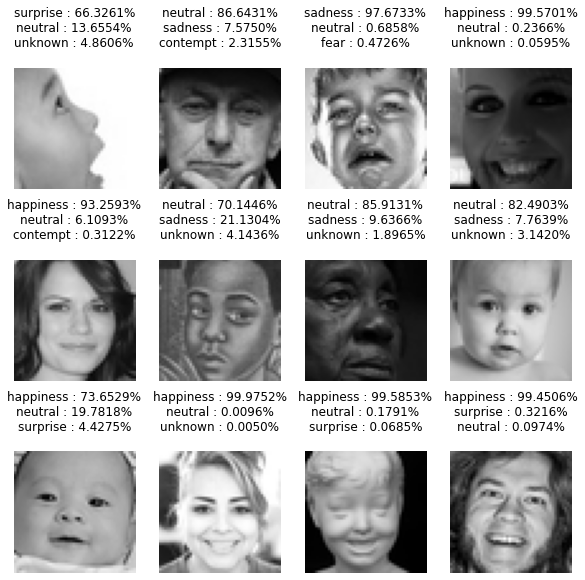

In [2]:
cols, rows = 4, 3
img_num = cols * rows
path_root = "../data/processed_data/test"
img_ids = np.random.choice(len(test_image_list), img_num)
orig_faces = np.empty(shape = (img_num, img_size, img_size, 3), dtype=np.int)

for i in range(len(img_ids)):
    img = cv2.imread(os.path.join(path_root, test_image_list[img_ids[i]]))
    orig_faces[i, :, :, :] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

faces = orig_faces.copy()
faces = faces.astype(np.float32)
faces /=  255.
faces -= 0.5
faces *= 2.

model = load_model(model_file)

# predict
results = model.predict(faces)

def make_label(results):
    top_k = 3
    inds = np.argsort(-results)
    top_k = inds[:top_k]
    top_confidences = results[inds]
    label = ''
    
    for i, (conf, ind) in enumerate(zip(top_confidences, top_k)):
        confidence = 100 * conf
        label += f'{emotion_list[ind]} : {confidence:.4f}%\n'
    return label

plt.rcParams["figure.figsize"] = (10,10)

for i in range(img_num):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(orig_faces[i])
    label = make_label(results[i])
    
    plt.title(label)
    plt.axis('off')
plt.savefig("resultn.png")